In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
import torch

In [2]:
from tqdm import trange

In [3]:
import einops

In [4]:
results_dir = 'results/20240907/'

In [5]:
gen_ind = [1, 16, 20, 34, 37]

In [6]:
import pickle
with open('data/014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None_eval_col.pkl', 'rb') as file:
    rule_file = pickle.load(file)

In [7]:
import pickle
with open('data/014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None_sample_col.pkl', 'rb') as file:
    attr_gen_file = pickle.load(file)

In [8]:
def get_metrics(x_gen,x_train): 
    """
        x_gen: (172, 3, 9), (num_samples, num_panels, num_pos)
        x_train: (4000, 3, 9), (num_samples, num_panels, num_pos)
    """
    # step 1: check for row memorization 
    x_train_row = x_train.reshape((-1, 27)) # (4000, 27)
    train_value_row, train_count_row = np.unique(x_train_row, return_counts=True, axis=0) # (3984, 27)
    x_gen_row = x_gen.reshape((-1, 27)) # (159, 27)
    c_gen_row = np.nan * np.zeros((len(x_gen_row), ))  
    for i, v in enumerate(x_gen_row): 
        idx_list = np.where(np.all(train_value_row == v, axis=1))[0]
        if len(idx_list)>0: 
            c_gen_row[i] = idx_list[0]
    m_row = np.sum(~np.isnan(c_gen_row))/len(c_gen_row) # metric 1: fraction of generated rows in the training data

    # step 2: check for panel memorization 
    x_train_panels = x_train.reshape((-1, 9))
    train_value_panel, train_count_panel = np.unique(x_train_panels, return_counts=True, axis=0)
    c_gen_panel = np.zeros((len(x_gen), 3))  
    for i in range(len(x_gen)): 
        for i_row in range(3): 
            v = x_gen[i, i_row]
            idx_list = np.where(np.all(train_value_panel == v, axis=1))[0]
            if len(idx_list)>0: 
                #c_gen_panel[i, i_row] = idx_list[0]
                c_gen_panel[i, i_row] = 1.0
    #c_gen_panel_binary = 1.0-np.isnan(c_gen_panel).astype(int)   # (159, 3)

    m_panel = np.sum(c_gen_panel)/(len(x_gen)*3) # metric 2: fraction of generated panels in the training data
    c_gen_panel_binary_sum = c_gen_panel.sum(1)
    m_panel_r3 = np.sum(c_gen_panel_binary_sum==3)/len(c_gen_panel_binary_sum) # 0.01
    m_panel_r2 = np.sum(c_gen_panel_binary_sum==2)/len(c_gen_panel_binary_sum) # 0.01
    m_panel_r1 = np.sum(c_gen_panel_binary_sum==1)/len(c_gen_panel_binary_sum) # 0.01
    m_panel_r0 = np.sum(c_gen_panel_binary_sum==0)/len(c_gen_panel_binary_sum) # 0.01

    return m_row, m_panel, m_panel_r3, m_panel_r2, m_panel_r1, m_panel_r0

In [9]:
step_list = [970000, 972500, 975000, 977500, 980000, 982500, 985000, 987500, 990000, 992500, 995000, 997500, 1000000]

In [10]:
len(step_list)

13

In [12]:
# first, get the rule for the generated samples 
count_list = []
m_row_list = []
m_panel_list = []
m_panel_r3_list = []
m_panel_r2_list = []
m_panel_r1_list = []
m_panel_r0_list = []

for i_rule in trange(30): 

    if i_rule<10: 
        i_attr = 0 
    elif i_rule<20 and i_rule>=10:
        i_attr = 1
    else:
        i_attr = 2

    x_gen_rule = []
    for step in step_list: 

        generated_samples = attr_gen_file[step]
        attr_tsr_list = torch.round(generated_samples).int() # convert attr 
        attr_gen = einops.rearrange(attr_tsr_list, 'b attr (row h) (p w) -> b row p (h w) attr', row=3, p=3)  # [2048, 3, 3, 9, 3]

        for i_sample in range(2048): 
            groundtruth = rule_file[step]['rule_col'][i_sample]
            for i_row in range(3): 
                r = groundtruth[i_row]
                if i_rule in r: 
                    x_gen_rule.append(attr_gen[i_sample, i_row, :, :, i_attr])

    x_gen_rule = np.asarray(x_gen_rule) # (172, 3, 9)
    count_list.append(len(x_gen_rule))

    x_train = np.load('results/20240907/x_train.npy')[i_rule,:,:,:,:,i_attr].reshape((-1, 3, 9)) # b row p (h w) attr'

    m_row, m_panel, m_panel_r3, m_panel_r2, m_panel_r1, m_panel_r0 = get_metrics(x_gen_rule,x_train)

    m_row_list.append(m_row)
    m_panel_list.append(m_panel)
    m_panel_r3_list.append(m_panel_r3)
    m_panel_r2_list.append(m_panel_r2)
    m_panel_r1_list.append(m_panel_r1)
    m_panel_r0_list.append(m_panel_r0)

  0%|          | 0/30 [00:00<?, ?it/s]/opt/anaconda3/envs/pytorch39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 30/30 [00:28<00:00,  1.04it/s]


In [13]:
count_list = np.asarray(count_list)
m_row_list = np.asarray(m_row_list)
m_panel_list = np.asarray(m_panel_list)
m_panel_r3_list = np.asarray(m_panel_r3_list)
m_panel_r2_list = np.asarray(m_panel_r2_list)
m_panel_r1_list = np.asarray(m_panel_r1_list)
m_panel_r0_list = np.asarray(m_panel_r0_list)

In [14]:
m_panel_list.mean()

0.7028453880713817

In [15]:
np.savez(results_dir+'metric_gen', count_list=count_list, 
m_row_list=m_row_list, m_panel_list=m_panel_list, m_panel_r3_list=m_panel_r3_list, 
m_panel_r2_list=m_panel_r2_list, m_panel_r1_list=m_panel_r1_list, m_panel_r0_list=m_panel_r0_list)

In [16]:
R_label_list = ['Const', 'Prog-2', 'Prog-1', 'Prog+1', 'Prog+2', 'Arith+', 'Arith-', 'XOR', 'OR', 'AND']
a_label_list = ['Shape', 'Size', 'Shade']

In [17]:
m_panel_r0_list.mean()

0.2720304797994378

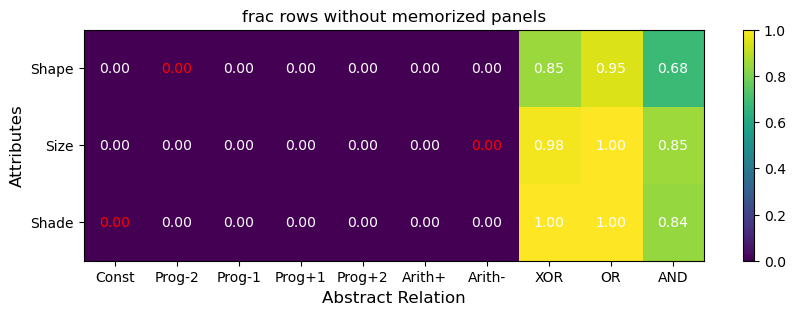

In [20]:
A = m_panel_r0_list.reshape(3, 10)

plt.figure(figsize=(10,3))
plt.imshow(A, aspect='auto')
plt.colorbar()
plt.title('frac rows without memorized panels', fontsize=12)
plt.xlabel('Abstract Relation', fontsize=12)
plt.ylabel('Attributes', fontsize=12)

# set xticks label
t = plt.xticks(np.arange(10), R_label_list, fontsize=10)
t = plt.yticks(np.arange(3), a_label_list, fontsize=10)

for i in range(3):
    for j in range(10):
        i_rule = i*10+j
        if i_rule in gen_ind: 
            plt.text(j, i, f'{A[i, j]:.2f}',ha='center', va='center', color='red', fontsize=10)
        else: 
            plt.text(j, i, f'{A[i, j]:.2f}',ha='center', va='center', color='white', fontsize=10)


In [ ]:
m_panel_r1_list.mean()

In [ ]:
A = m_panel_r1_list.reshape(4, 10)

plt.figure(figsize=(10,4))
plt.imshow(A, aspect='auto')
plt.colorbar()
plt.title('frac rows with 1 memorized panels', fontsize=12)
plt.xlabel('Abstract Relation', fontsize=12)
plt.ylabel('Attributes', fontsize=12)

# set xticks label
t = plt.xticks(np.arange(10), R_label_list, fontsize=10)
t = plt.yticks(np.arange(4), a_label_list, fontsize=10)

for i in range(4):
    for j in range(10):
        i_rule = i*10+j
        if i_rule in gen_ind: 
            plt.text(j, i, f'{A[i, j]:.2f}',ha='center', va='center', color='red', fontsize=10)
        else: 
            plt.text(j, i, f'{A[i, j]:.2f}',ha='center', va='center', color='white', fontsize=10)


In [ ]:
m_panel_r3_list+m_panel_r2_list+m_panel_r1_list+m_panel_r0_list

In [ ]:
A = m_panel_r2_list.reshape(4, 10)

plt.figure(figsize=(10,4))
plt.imshow(A, aspect='auto')
plt.colorbar()
plt.title('frac rows with 2 memorized panels', fontsize=12)
plt.xlabel('Abstract Relation', fontsize=12)
plt.ylabel('Attributes', fontsize=12)

# set xticks label
t = plt.xticks(np.arange(10), R_label_list, fontsize=10)
t = plt.yticks(np.arange(4), a_label_list, fontsize=10)

for i in range(4):
    for j in range(10):
        i_rule = i*10+j
        if i_rule in gen_ind: 
            plt.text(j, i, f'{A[i, j]:.2f}',ha='center', va='center', color='red', fontsize=10)
        else: 
            plt.text(j, i, f'{A[i, j]:.2f}',ha='center', va='center', color='white', fontsize=10)


In [ ]:
m_panel_r3_list.mean()

In [ ]:
A = m_panel_r3_list.reshape(4, 10)

plt.figure(figsize=(10,4))
plt.imshow(A, aspect='auto')
plt.colorbar()
plt.title('frac rows with 3 memorized panels', fontsize=12)
plt.xlabel('Abstract Relation', fontsize=12)
plt.ylabel('Attributes', fontsize=12)

# set xticks label
t = plt.xticks(np.arange(10), R_label_list, fontsize=10)
t = plt.yticks(np.arange(4), a_label_list, fontsize=10)

for i in range(4):
    for j in range(10):
        i_rule = i*10+j
        if i_rule in gen_ind: 
            plt.text(j, i, f'{A[i, j]:.2f}',ha='center', va='center', color='red', fontsize=10)
        else: 
            plt.text(j, i, f'{A[i, j]:.2f}',ha='center', va='center', color='white', fontsize=10)


In [ ]:
A = m_panel_list.reshape(4, 10)

plt.figure(figsize=(10,4))
plt.imshow(A, aspect='auto')
plt.colorbar()
plt.title('frac memorized panel', fontsize=12)
plt.xlabel('Abstract Relation', fontsize=12)
plt.ylabel('Attributes', fontsize=12)

# set xticks label
t = plt.xticks(np.arange(10), R_label_list, fontsize=10)
t = plt.yticks(np.arange(4), a_label_list, fontsize=10)

for i in range(4):
    for j in range(10):
        i_rule = i*10+j
        if i_rule in gen_ind: 
            plt.text(j, i, f'{A[i, j]:.2f}',ha='center', va='center', color='red', fontsize=10)
        else: 
            plt.text(j, i, f'{A[i, j]:.2f}',ha='center', va='center', color='white', fontsize=10)


In [ ]:
A = m_row_list.reshape(4, 10)

plt.figure(figsize=(10,4))
plt.imshow(A, aspect='auto')
plt.colorbar()
plt.title('frac memorized rows', fontsize=12)
plt.xlabel('Abstract Relation', fontsize=12)
plt.ylabel('Attributes', fontsize=12)

# set xticks label
t = plt.xticks(np.arange(10), R_label_list, fontsize=10)
t = plt.yticks(np.arange(4), a_label_list, fontsize=10)

for i in range(4):
    for j in range(10):
        i_rule = i*10+j
        if i_rule in gen_ind: 
            plt.text(j, i, f'{A[i, j]:.3f}',ha='center', va='center', color='red', fontsize=10)
        else: 
            plt.text(j, i, f'{A[i, j]:.3f}',ha='center', va='center', color='white', fontsize=10)


In [ ]:
A = count_list.reshape(4, 10)

plt.figure(figsize=(10,4))
plt.imshow(A, aspect='auto')
plt.colorbar()
plt.title('total# generated rows', fontsize=12)
plt.xlabel('Abstract Relation', fontsize=12)
plt.ylabel('Attributes', fontsize=12)

# set xticks label
t = plt.xticks(np.arange(10), R_label_list, fontsize=10)
t = plt.yticks(np.arange(4), a_label_list, fontsize=10)

for i in range(4):
    for j in range(10):
        i_rule = i*10+j
        if i_rule in gen_ind: 
            plt.text(j, i, f'{A[i, j]:.0f}',ha='center', va='center', color='red', fontsize=10)
        else: 
            plt.text(j, i, f'{A[i, j]:.0f}',ha='center', va='center', color='white', fontsize=10)
